# SARIMA Forecast

## 01 - Background

Our goal in this challenge is to apply the basic concepts of time series analysis to one-dimensional data (sales depending on the date).

In this challenge, we'll go through the following steps:
1. load and visualize the data;
2. train our models and make predictions;
3. use an econometric approach to model the series and be able to forecast it;
4. use Machine Learning to hack this model.

The dataset is courtesy of [Machine Learning Mastery](https://github.com/jbrownlee/). Run the line below to download it!

In [34]:
!curl https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv > data/monthly_champagne_sales.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  1596  100  1596    0     0   5597      0 --:--:-- --:--:-- --:--:--  5679


## 02 - Load Data
Let's start by loading the time series of the challenge

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/monthly_champagne_sales.csv")
df.head()


,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


👉 Convert the DataFrame's "Month" column to `Datetime` objects, and set it as the index to make it look like this:
<br>

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/05-ML/09-Time-Series/monthly_champagne_sales_objective.png" width=180>

In [36]:
df['Month'] = pd.to_datetime(df['Month'])

df.set_index('Month', inplace=True)

print(df.head())


            Sales
Month            
1964-01-01   2815
1964-02-01   2672
1964-03-01   2755
1964-04-01   2721
1964-05-01   2946


### Alternative - Let Pandas do the Work

In [37]:
# We can also use pandas magic to handle the conversions from the start
df = pd.read_csv("data/monthly_champagne_sales.csv", parse_dates=['Month'], index_col='Month')
df.head()


,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


## 04 - Visualize and Interpret the Data

Well done, thanks to this re-indexing, you should now be able to plot the "Sales" (y-axis) as a function of the time (x-axis) easily

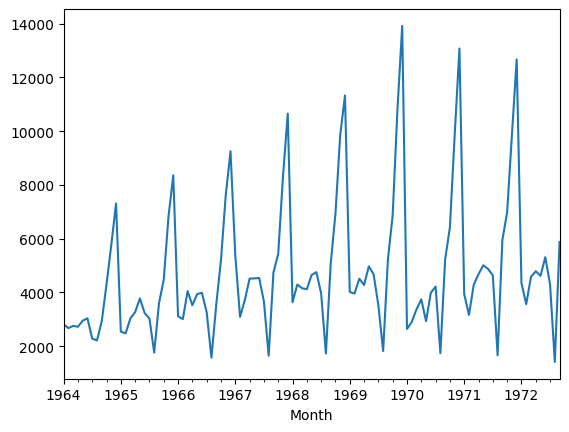

In [38]:
df["Sales"].plot();


If your code is correct, you should be able to see that this time series (TS) is:
- Not stationary (mean and variance are not constant).
- Exhibits strong seasonality.
- Seems to have a trend.

Let's see a decomposition of the data between **trend**, **seasonality** and **noise**. To do that, you have to make use of statsmodels' [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Read the docs and make sure you understand what this function is doing and how to use it, then:
1. Plot the "Sales" with an "additive" model
2. Plot the "Sales" with a "multiplicative" model

Pro tips: end your statsmodels plot method calls with a semicolon (`;`) to avoid double-plotting issues!

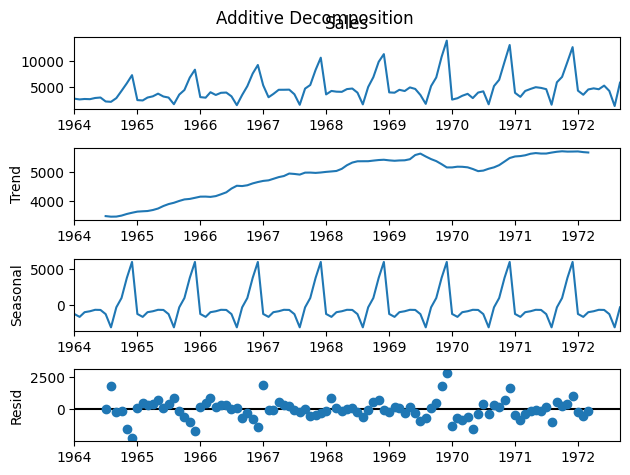

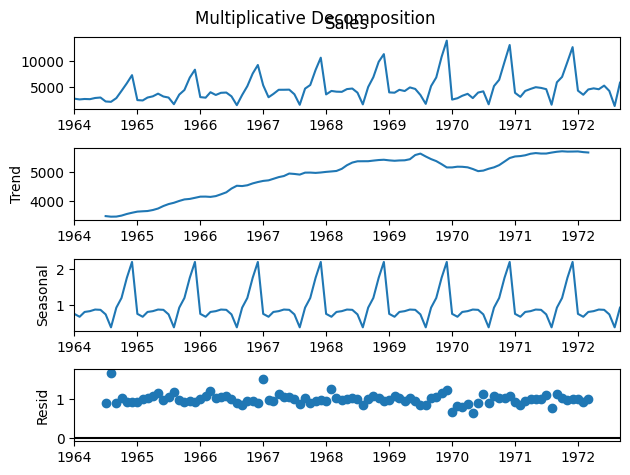

In [39]:
import statsmodels.api as sm

result_add = sm.tsa.seasonal_decompose(df["Sales"], model="additive")
result_add.plot();
plt.suptitle("Additive Decomposition");

result_mul = sm.tsa.seasonal_decompose(df["Sales"], model="multiplicative")
result_mul.plot();
plt.suptitle("Multiplicative Decomposition");

plt.show();


👉 De-seasonalize this time series using the decomposition of your choice

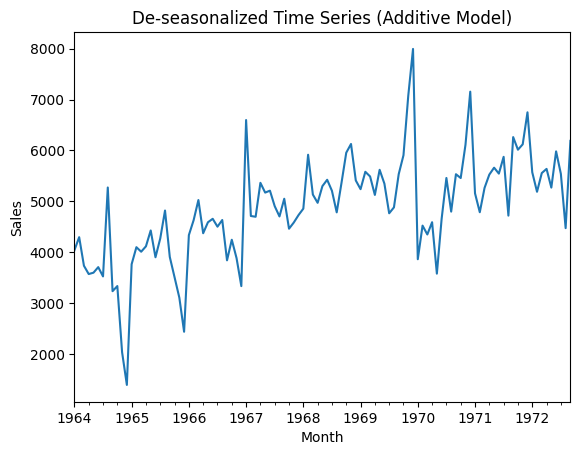

In [40]:
de_seasonalized_additive = df["Sales"] - result_add.seasonal

de_seasonalized_additive.plot()
plt.title("De-seasonalized Time Series (Additive Model)")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()


☝️ We could fit an ARIMA model on a "deseasonalized" version of this time series, and then re-compose it after our forecast. But in this challenge, we will use SARIMA models to _directly_ fit the original time series!

## 05 - Split the Data (train/test)


For time series, we cannot randomly sample points to be in the test set. The test set needs to be "out-of-time", that is, strictly in the future of the test set. For this exercise, we will use data up to 1970 for training, and anything after that will be used for the test.

👉 create `df_train` and `df_test`, splitting the DataFrame before 1970 for the training and after (or equal to) for the testing

In [41]:
cutoff_year = 1970

df_train = df[df.index.year < cutoff_year]

df_test = df[df.index.year >= cutoff_year]

print("Training set shape:", df_train.shape)
print("Testing set shape:", df_test.shape)


Training set shape: (72, 1)
Testing set shape: (33, 1)


## 06 - SARIMA
We will analyze the data using a SARIMA model (Seasonal Auto-Regressive Integrated Moving Average).


We need to :
- find how to stationarize the time series (I in SARIMA)
- find the auto-regressive (AR) part
- find the moving average (MA) part
- find the seasonality (S)

### Step 1: Check Stationarity

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

A glance at the plot above should be sufficient to convince you that the time series is not stationary.

Double check the stationarity of `df["Sales"]` using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) and especially its p-value

In [42]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["Sales"])

p_value = result[1]
print("Augmented Dickey-Fuller Test p-value:", p_value)

if p_value <= 0.05:
    print("The time series is stationary (p-value <= 0.05)")
else:
    print("The time series is not stationary (p-value > 0.05)")


Augmented Dickey-Fuller Test p-value: 0.36391577166024813
The time series is not stationary (p-value > 0.05)


The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  

If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

Ideally, p is *much* smaller than 0.05.

Another way to look for stationarity is to look at the autocorrelation function (ACF).

Plot the ACF of the time series. You should see a large peak at lag 12, indicating strong yearly seasonality.

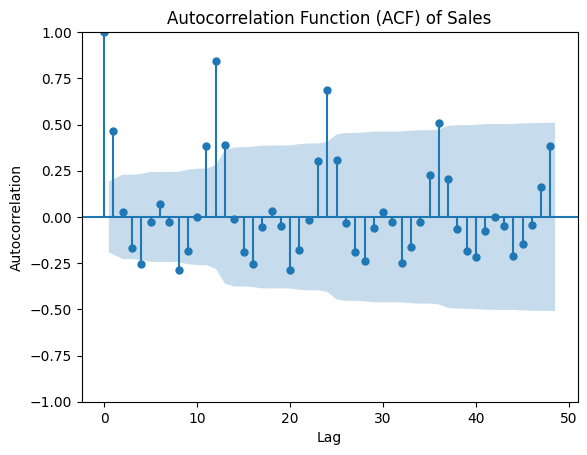

In [43]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df["Sales"], lags=48);
plt.title("Autocorrelation Function (ACF) of Sales")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()


### Step 2 - Seasonal Differencing (D)

We have a strong seasonality with a period of 12 months.

Do a **seasonal differencing of lag 12** on the time series, plot the differenced data, and check the ACF plot (+ADF test) again.

Don't forget to drop NaN's.

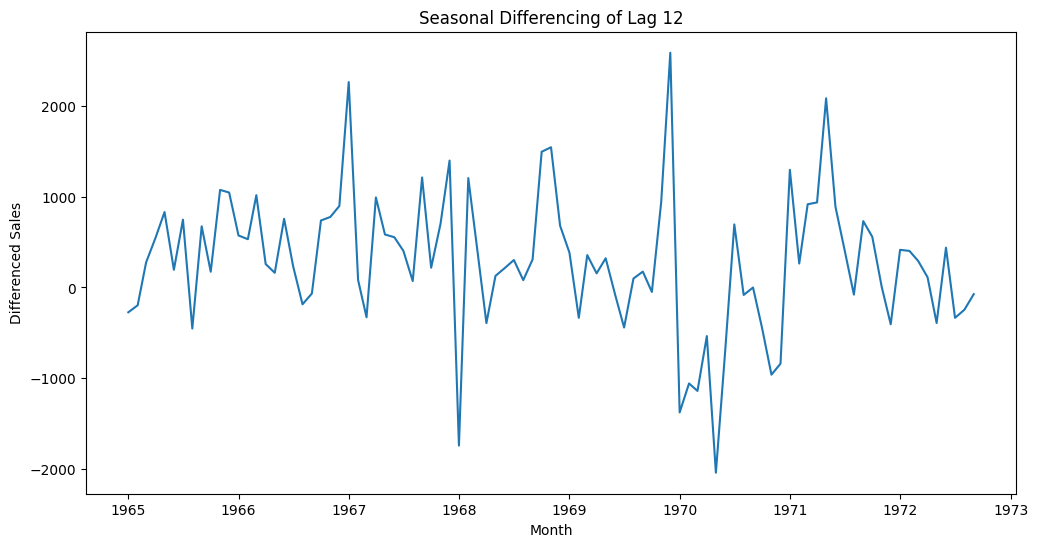

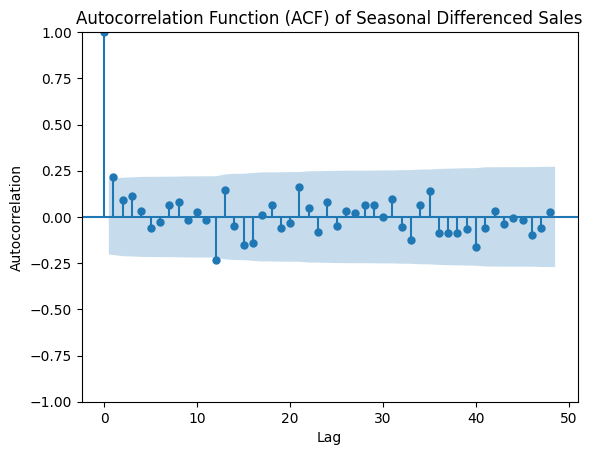

Augmented Dickey-Fuller Test p-value after seasonal differencing: 2.060579696813685e-11
The differenced time series is stationary (p-value <= 0.05)


In [44]:
df_seasonal_diff = df["Sales"].diff(12).dropna()

plt.figure(figsize=(12, 6))
plt.plot(df_seasonal_diff)
plt.title("Seasonal Differencing of Lag 12")
plt.xlabel("Month")
plt.ylabel("Differenced Sales")
plt.show()

plot_acf(df_seasonal_diff, lags=48);
plt.title("Autocorrelation Function (ACF) of Seasonal Differenced Sales")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

result_diff = adfuller(df_seasonal_diff)
p_value_diff = result_diff[1]
print("Augmented Dickey-Fuller Test p-value after seasonal differencing:", p_value_diff)

if p_value_diff <= 0.05:
    print("The differenced time series is stationary (p-value <= 0.05)")
else:
    print("The differenced time series is not stationary (p-value > 0.05)")


☝️ One single seasonal differencing seems enough to stationarize the TS.  
D=1 (1 seasonal diff) and m=12 (seasonality = 12) for SARIMA(p,d,q, P,D,Q,m)

### Step 3 - Differencing (d)

If the time series is still not stationary, it needs to be stationarized through *differencing*. It means that we take the difference between each value and the preceding one (*first difference*).

Do we need further differencing after removing the seasonality?

Check the ACF and ADF after running an additional first-order diff(1) on your diff(12) series.

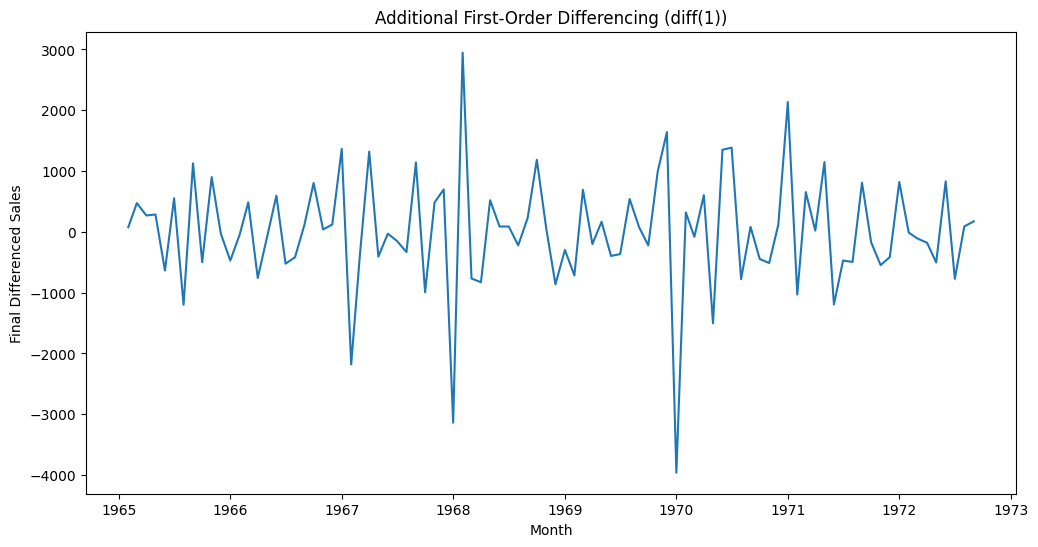

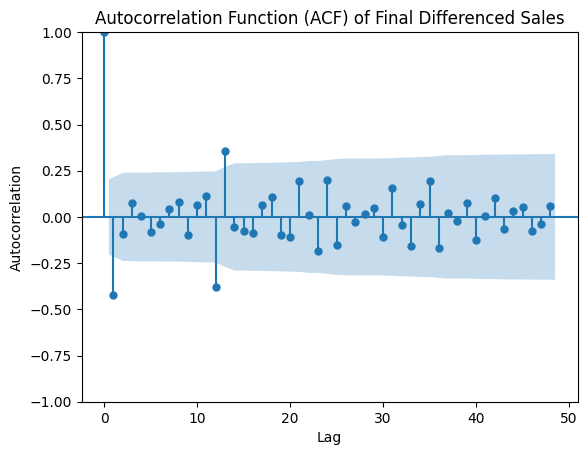

Augmented Dickey-Fuller Test p-value after additional differencing: 0.00026504628492935025
The final differenced time series is stationary (p-value <= 0.05)


In [45]:
df_final_diff = df_seasonal_diff.diff(1).dropna()

plt.figure(figsize=(12, 6))
plt.plot(df_final_diff)
plt.title("Additional First-Order Differencing (diff(1))")
plt.xlabel("Month")
plt.ylabel("Final Differenced Sales")
plt.show()

plot_acf(df_final_diff, lags=48);
plt.title("Autocorrelation Function (ACF) of Final Differenced Sales")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

result_final_diff = adfuller(df_final_diff)
p_value_final_diff = result_final_diff[1]
print("Augmented Dickey-Fuller Test p-value after additional differencing:", p_value_final_diff)

if p_value_final_diff <= 0.05:
    print("The final differenced time series is stationary (p-value <= 0.05)")
else:
    print("The final differenced time series is not stationary (p-value > 0.05)")


👉 Additional differencing made both the p-value and the ACF look worse! 
We can select (d=0) and (D=1)

### Step 4 - Select AR(p, P) and MA(q, Q) Terms

You will now use the ACF and PACF plots to decide whether to include an AR term(s), MA term(s), or both.

- The autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to your **fully differentiated** series allows you to select an MA number (`q`)
- MA($\color{blue}{q}$) = number of lags beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d+D)}}$ cuts off


- The partial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to your **fully differentiated** series allows you to select AR (`p`)
- AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d+D)}}$  cuts off

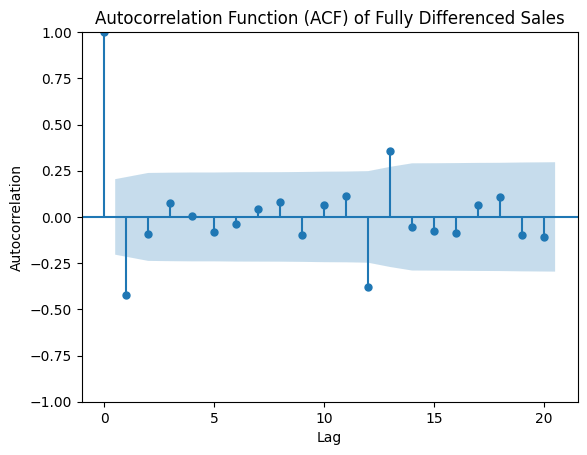

/Users/reecepalmer/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


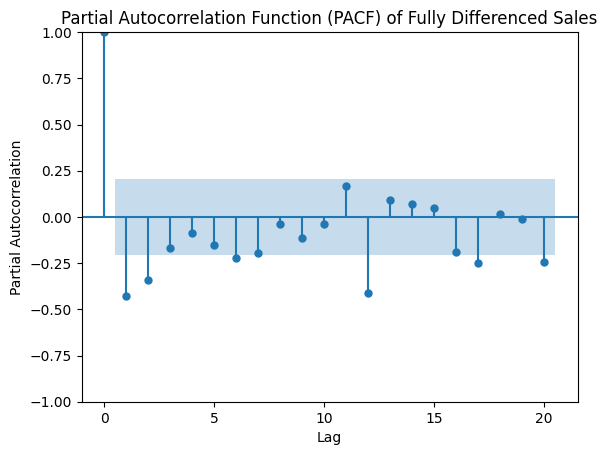

In [46]:
plot_acf(df_final_diff, lags=20);
plt.title("Autocorrelation Function (ACF) of Fully Differenced Sales")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

plot_pacf(df_final_diff, lags=20);
plt.title("Partial Autocorrelation Function (PACF) of Fully Differenced Sales")
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation")
plt.show()


☝️ It seems like there are no significant peaks in either ACF or PACF, so most likely p=q=0.  
Our first guess for SARIMA is therefore d=0, p=q=0, D=1 and m=12.  

How to find values for P and Q? Here, we will let `pdarima` try values 1 and 0 for P and Q with a grid_search for us.
If you want to find these coefficients by yourself, [read this](https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/) for some rules of thumb

👉 Run [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for the training set. Set seasonal=True, m=12 and D=1. Search for p and q, P and Q from 0 to 2. Then, print the summary of the model with model.summary().
Use `njobs=-1, trace=True, error_action='ignore', suppress_warnings=True`

In [47]:
from pmdarima import auto_arima

model = auto_arima(
    df_train["Sales"],
    seasonal=True,
    m=12,
    D=1,
    start_p=0, start_q=0, max_p=2, max_q=2,
    start_P=0, start_Q=0, max_P=2, max_Q=2,
    n_jobs=-1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

print(model.summary())


/Users/reecepalmer/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=954.252, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=957.794, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=957.973, Time=0.07 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=974.624, Time=0.03 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=956.000, Time=0.09 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=955.904, Time=0.09 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=957.929, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=956.182, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=956.250, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=958.187, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 0.732 seconds
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   72
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood 

The best model found is `ARIMA(0,0,0)(0,1,0)[12]`!
This means that the time series considered does not justify adding any "auto-regressive" or "moving average" modelling beyond simple "seasonal differencing".

Such a "poor" model is only likely to predict a repetition of the last seasonal pattern detected, along with the prolongation of the mean increasing trend. Let's check it out

👉 Use `model.predict` with `n_periods` = length of the test set to save the following three predictions
- `central`
- `upper`
- `lower`

Save them as a Pandas Series, and index them by the same index as your `y_test`

In [48]:
n_periods = len(df_test)

forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

central = forecast
lower_pred, upper_pred = conf_int[:, 0], conf_int[:, 1]

central_series = pd.Series(central, index=df_test.index)
lower = pd.Series(lower_pred, index=df_test.index)
upper = pd.Series(upper_pred, index=df_test.index)

print("Central Prediction Series:")
print(central_series.head())

print("\nLower Prediction Series:")
print(lower_series.head())

print("\nUpper Prediction Series:")
print(upper_series.head())


Central Prediction Series:
Month
1970-01-01    4463.05
1970-02-01    4404.05
1970-03-01    4957.05
1970-04-01    4723.05
1970-05-01    5415.05
dtype: float64

Lower Prediction Series:
Month
1970-01-01    3159.618374
1970-02-01    3100.618374
1970-03-01    3653.618374
1970-04-01    3419.618374
1970-05-01    4111.618374
dtype: float64

Upper Prediction Series:
Month
1970-01-01    5766.481626
1970-02-01    5707.481626
1970-03-01    6260.481626
1970-04-01    6026.481626
1970-05-01    6718.481626
dtype: float64


👇 Run the cell below to plot your predictions against reality

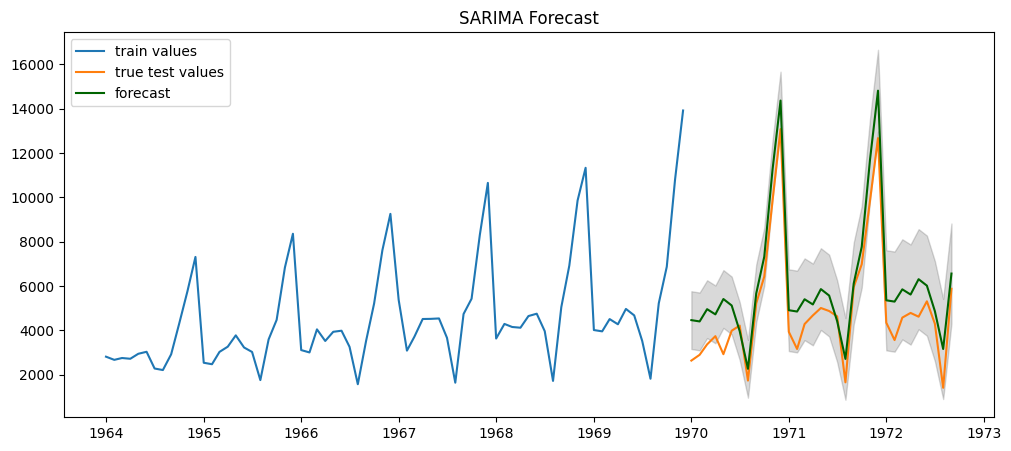

In [49]:
# Plot
plt.figure(figsize=(12, 5), dpi=100)

plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")

plt.fill_between(
    lower.index,
    lower,
    upper,
    color='k', alpha=.15
)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()


👉 Try to assign non-null values to `p`, `d`, `P`, `D` on your SARIMA and re-plot this chart to compare effects!

# OPTIONAL - Machine Learning Approach

### Model with a forecast horizon = 1 month only

We will now fit a non-linear model such as a Random Forest. The idea is to predict a value from the last ones. 

👉 Create new columns in `df` that are a shifted version of `df['Sales']`. Do it with a shift from 1 to 12.

In [50]:
shift_range = range(1, 13)

for shift in shift_range:
    df[f'Sales_Shift_{shift}'] = df['Sales'].shift(shift)


print(df.head())


            Sales  Sales_Shift_1  Sales_Shift_2  Sales_Shift_3  Sales_Shift_4  \
Month                                                                           
1964-01-01   2815            NaN            NaN            NaN            NaN   
1964-02-01   2672         2815.0            NaN            NaN            NaN   
1964-03-01   2755         2672.0         2815.0            NaN            NaN   
1964-04-01   2721         2755.0         2672.0         2815.0            NaN   
1964-05-01   2946         2721.0         2755.0         2672.0         2815.0   

            Sales_Shift_5  Sales_Shift_6  Sales_Shift_7  Sales_Shift_8  \
Month                                                                    
1964-01-01            NaN            NaN            NaN            NaN   
1964-02-01            NaN            NaN            NaN            NaN   
1964-03-01            NaN            NaN            NaN            NaN   
1964-04-01            NaN            NaN            NaN       

👉 Instantiate (don't train) a `random forest` algorithm to predict Sales based on your shifted features

In [51]:
from sklearn.ensemble import RandomForestRegressor

X = df.dropna().drop('Sales', axis=1)
y = df.dropna()['Sales']

random_forest_model = RandomForestRegressor(random_state=42)

print(random_forest_model)


RandomForestRegressor(random_state=42)


👉 You can use the following function to test it. It takes the true y values (`data` which should be a NumPy array), the indexes of the test samples (`test_indexes`), the predictor (`predictor`: your random forest algorithm), and the shifted columns (`full_X` which should be a NumPy array).

In [52]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score

def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0

    for _index in test_indexes:
        train_data = y_true[:_index]
        current_ground_truth = y_true[_index]
        current_ground_truth_features = full_X[_index,:]
        train_features = full_X[:_index]

        # train the model on all data points until (t-1) to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)

        i += 1

    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))

    return ground_truth, predictions, mape


To improve our model, we can do some feature engineering. You will add moving averages to the data used to train the random forest.

Try to create 3 new columns in `df`: one which is the rolling average of `df[Sales]` with a window of 12, one with a window of 3, and one with a window of 2. This will have the effect of isolating the trend and allowing the algorithm to learn it. Plot these data.


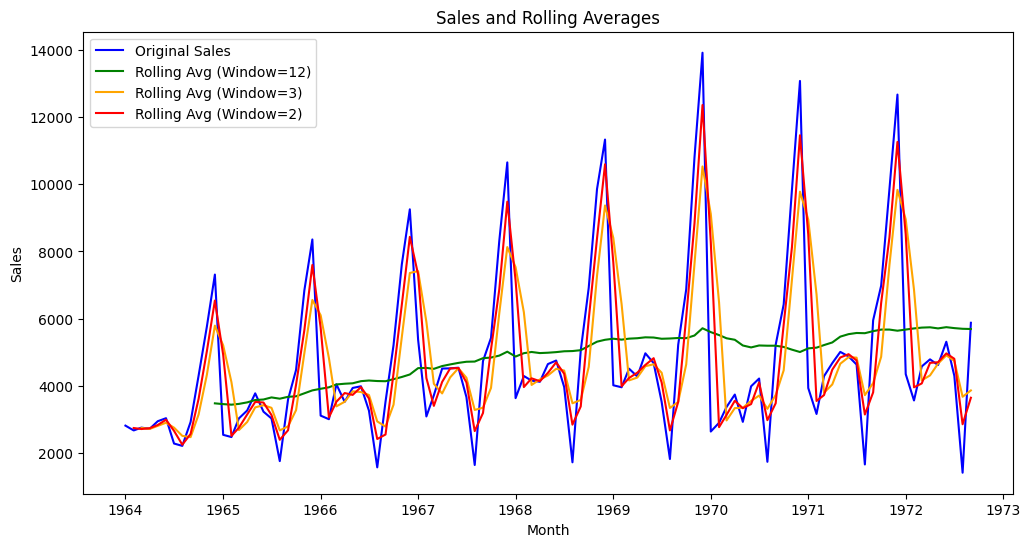

In [54]:
df['Rolling_Avg_12'] = df['Sales'].rolling(window=12).mean()
df['Rolling_Avg_3'] = df['Sales'].rolling(window=3).mean()
df['Rolling_Avg_2'] = df['Sales'].rolling(window=2).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Sales'], label='Original Sales', color='blue')
plt.plot(df['Rolling_Avg_12'], label='Rolling Avg (Window=12)', color='green')
plt.plot(df['Rolling_Avg_3'], label='Rolling Avg (Window=3)', color='orange')
plt.plot(df['Rolling_Avg_2'], label='Rolling Avg (Window=2)', color='red')

plt.title('Sales and Rolling Averages')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.show()


You can also add a stronger smoothing predictor using the exponential moving average (hint: method `.ewm` with a `halflife` of 2, 3, and 12), which statistically optimizes an AR process. Plot these data.

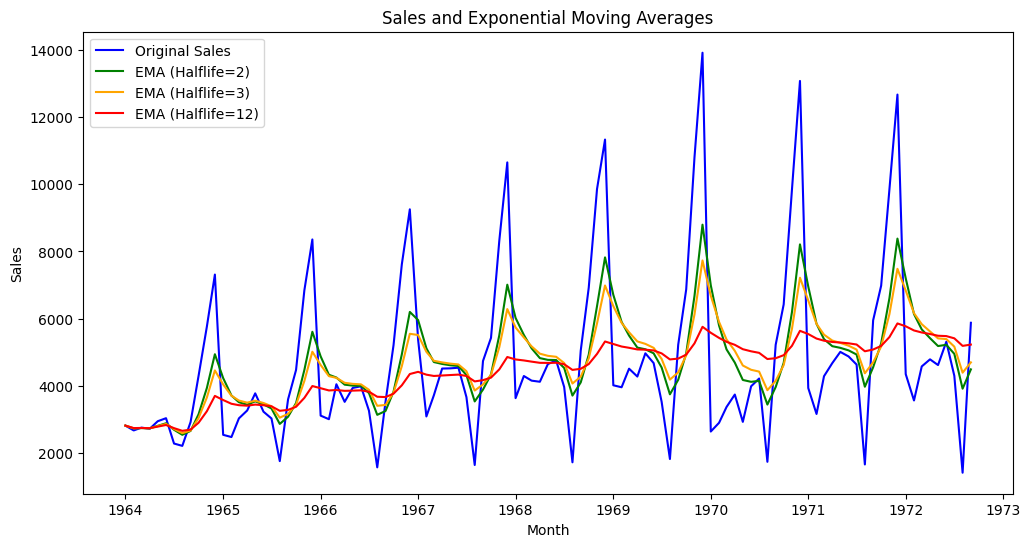

In [55]:
df['EMA_2'] = df['Sales'].ewm(halflife=2).mean()
df['EMA_3'] = df['Sales'].ewm(halflife=3).mean()
df['EMA_12'] = df['Sales'].ewm(halflife=12).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Sales'], label='Original Sales', color='blue')
plt.plot(df['EMA_2'], label='EMA (Halflife=2)', color='green')
plt.plot(df['EMA_3'], label='EMA (Halflife=3)', color='orange')
plt.plot(df['EMA_12'], label='EMA (Halflife=12)', color='red')

plt.title('Sales and Exponential Moving Averages')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.show()


You should see a better MAPE!

Try to look at the importance of each feature. What do you find?


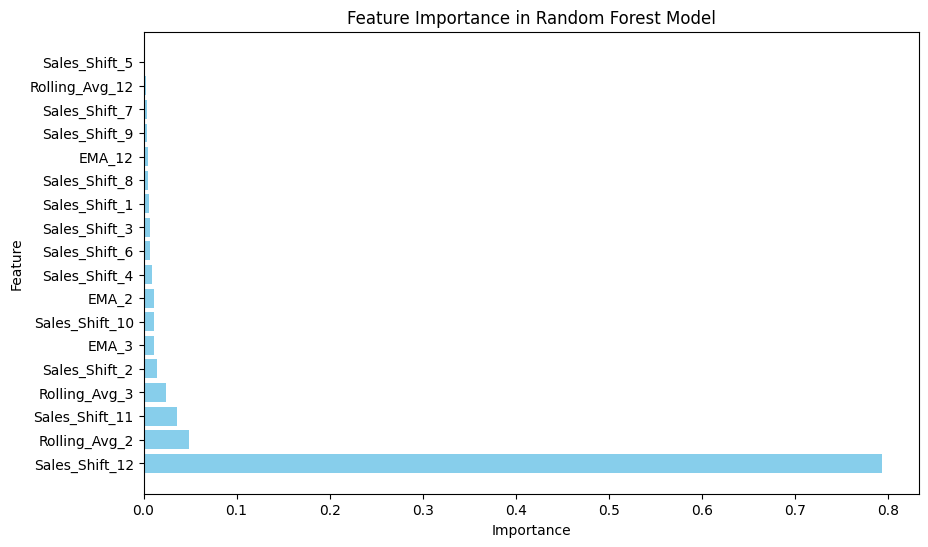

           Feature  Importance
11  Sales_Shift_12    0.793284
14   Rolling_Avg_2    0.048351
10  Sales_Shift_11    0.035471
13   Rolling_Avg_3    0.024329
1    Sales_Shift_2    0.014705
16           EMA_3    0.011784
9   Sales_Shift_10    0.011131
15           EMA_2    0.010787
3    Sales_Shift_4    0.008947
5    Sales_Shift_6    0.007143
2    Sales_Shift_3    0.006675
0    Sales_Shift_1    0.006373
7    Sales_Shift_8    0.005177
17          EMA_12    0.004691
8    Sales_Shift_9    0.004018
6    Sales_Shift_7    0.003327
12  Rolling_Avg_12    0.002532
4    Sales_Shift_5    0.001274


In [56]:
X = df.dropna().drop(['Sales'], axis=1)
y = df.dropna()['Sales']

random_forest_model = RandomForestRegressor(random_state=42)

random_forest_model.fit(X, y)

feature_importances = random_forest_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

print(feature_importance_df)


### Out-of-Sample Forecast Models

Let's now try to beat SARIMA in the "out-of-sample" prediction. 

👉 Train _one model per horizon of forecast_ (from `1`-month horizon to `len(y_test)` months)  
👉 Evaluate MAPE and compare with SARIMA